In [13]:
from keras.applications.vgg16 import VGG16
from pickle import dump
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from os import listdir


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

from tqdm.notebook import tqdm 
from nltk.translate.bleu_score import corpus_bleu
import os

import pickle

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.models import load_model


### ----------------------------------------------Feature extraction using VGG16 model----------------------------------------------

In [14]:
# Load the VGG16 pre-trained model for image feature extraction
v_model = VGG16()

# Restructure the VGG16 model to remove the last classification layer, keeping only the feature extraction layers
v_model = Model(inputs=v_model.inputs, outputs=v_model.layers[-2].output)

# Print a summary of the modified VGG16 model to view its architecture
print(v_model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
# Function to extract image features using a pre-trained VGG16 model
def extract_features(directory):
    
    # Create a dictionary to store image features
    features = dict()
    
    # Iterate through each photo in the provided directory
    for name in tqdm(listdir(directory)):
        # Load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # Reshape data for the VGG model
        image = image.reshape((1, 224, 224, 3))
        
        # Prepare the image for the VGG model (normalize and preprocess)
        image = preprocess_input(image)
        
        # Get features by passing the image through the VGG model
        feature = v_model.predict(image, verbose=0)
        
        # Get the image ID by splitting the file name at the dot
        image_id = name.split('.')[0]
        
        # Store the extracted feature in the dictionary with the image ID as the key
        features[image_id] = feature
    
    # Return the dictionary of image features
    return features


#### feature extraction of the images is done once and saved.So no need to extract again and again since it will take time.

In [524]:
# # Specify the directory containing the images
# directory = 'Flicker8k_Dataset'

# # Call the 'extract_features' function to extract features from all images in the specified directory
# features = extract_features(directory)

# # Print the number of extracted features
# print('Extracted Features: %d' % len(features))

# # Save the extracted features to a file named 'features.pkl' using pickle
# pickle.dump(features, open('features.pkl', 'wb'))


  0%|          | 0/8091 [00:00<?, ?it/s]

Extracted Features: 8091


#### Importing saved feature extracted file

In [16]:
# Load previously saved image features from the 'features.pkl' file using pickle
features = pickle.load(open('features.pkl', 'rb'))

## ---------------------------------------------- Importing captions ----------------------------------------------

In [17]:
# Function to load a text document into memory
def load_doc(filename):
    # Open the file in read-only mode
    file = open(filename, 'r')
    
    # Read all the text content from the file
    text = file.read()
    
    # Close the file to free up system resources
    file.close()
    
    # Return the loaded text
    return text


In [18]:
filename = 'captions.txt'
# Load captions from 'captions.txt'
doc = load_doc(filename)

## ---------------------------------------------- Preprocess the captions ----------------------------------------------

In [19]:
# Function to extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    

    for line in doc.split('\n')[1:]:
        tokens = line.split(",")
        
        # Skip lines with fewer than 2 tokens
        if len(tokens) < 2:
            continue
        
        # Extract image ID
        image_id = tokens[0].split('.')[0]
        
        # Initialize a list of descriptions for the image if not already created
        if image_id not in mapping:
            mapping[image_id] = list()
        
        # Extract and preprocess the image description
        image_desc = ' '.join(tokens[1:]).lower()
        image_desc = re.sub("[^a-z\s]", '', image_desc)
        image_desc = re.sub("\s\s+", " ", image_desc)
        image_desc = " ".join([word for word in image_desc.split() if len(word) > 1])
        image_desc = 'startseq ' + image_desc + ' endseq'
        
        # Append the preprocessed description to the list of descriptions for the image
        mapping[image_id].append(image_desc)
    
    return mapping


In [20]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Total_ids ',len(descriptions))

Total_ids  8091


In [21]:
# Creating a List of All Captions
all_captions = [caption for captions in descriptions.values() for caption in captions]

## ---------------------------------------------- Tokenizing Captions ----------------------------------------------

In [22]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [23]:
# Calculate maximum caption length
word_count = [len(caption.split(" ")) for caption in all_captions]
max_caption_length = max(word_count)

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index)

# Print results
print("Vocab Size:", vocab_size)
print("Max Caption Length:", max_caption_length)


Vocab Size: 8767
Max Caption Length: 34


## ------------------------------------ Creating generator to train in batches ----------------------------------------

In [24]:
# Data generator function
def data_generator(data_keys, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get captions associated with the current image
            captions = descriptions[image_id]

            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    input_seq, output_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified max caption length
                    input_seq = pad_sequences([input_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(input_seq)  # Input sequence
                    y_batch.append(output_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        yield [np.array(X1_batch), np.array(X2_batch)], np.array(y_batch)
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0


## ---------------------------------------- Model Architechture Creation ------------------------------------------

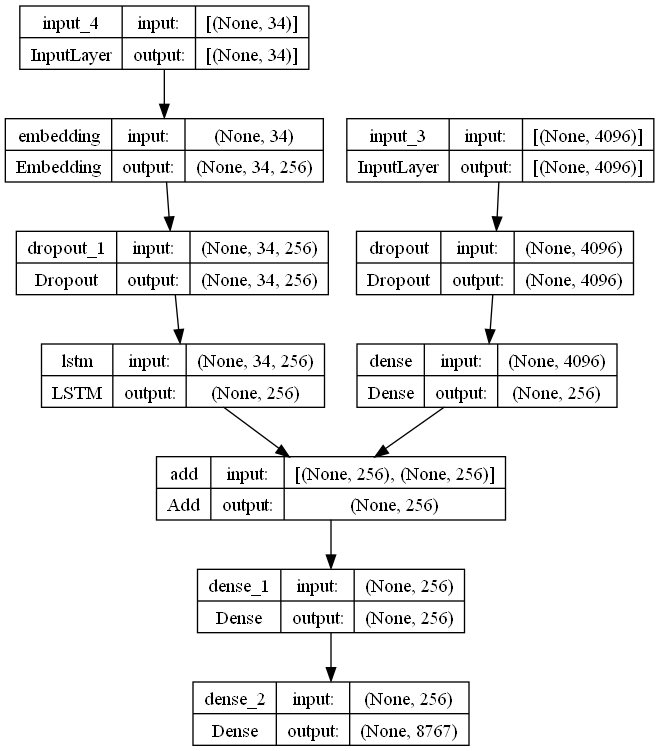

In [25]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])  # Combine image feature and sequence embeddings
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create and compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model's architecture
plot_model(model, show_shapes=True)


## ---------------------------------------------- Train and Test Split ----------------------------------------------

In [26]:
# Create a list of image IDs from extracted features
image_ids = list(features.keys())

# Split the image IDs into training and test sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

## ---------------------------------------------- Training the Model ----------------------------------------------

#### Model is created once and saved in multiple epochs. So no need to run next cell to train model. Or can run if necessary. 

In [25]:
# # Set the number of epochs and batch size
# epochs = 50
# batch_size = 32

# # Calculate the number of steps per epoch for training and validation
# steps_per_epoch = ceil(len(train) / batch_size)
# validation_steps = ceil(len(test) / batch_size)

# # Loop through the epochs for training
# for epoch in tqdm(range(1, epochs + 1)):
#     print(f"Epoch {epoch}/{epochs}")
    
#     # Set up data generators for training and validation
#     train_generator = data_generator(train, batch_size)
#     test_generator = data_generator(test, batch_size)
    
#     # Train the model for one epoch
#     model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
#               validation_data=test_generator, validation_steps=validation_steps,
#               verbose=1)
    
#     # Save the model checkpoints at specific epochs
#     if epoch in [20, 30, 40, 50]:
#         model.save(f'model{epoch}.h5')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
228/228 [==============================] - 82s 336ms/step - loss: 6.2770 - val_loss: 6.0644
Epoch 2/50
228/228 [==============================] - 71s 310ms/step - loss: 5.1374 - val_loss: 6.2549
Epoch 3/50
228/228 [==============================] - 68s 299ms/step - loss: 4.7292 - val_loss: 6.2729
Epoch 4/50
228/228 [==============================] - 69s 302ms/step - loss: 4.4535 - val_loss: 6.3706
Epoch 5/50
228/228 [==============================] - 77s 338ms/step - loss: 4.2514 - val_loss: 6.5846
Epoch 6/50
228/228 [==============================] - 73s 321ms/step - loss: 3.9426 - val_loss: 6.7563
Epoch 7/50
228/228 [==============================] - 71s 310ms/step - loss: 3.7148 - val_loss: 6.9173
Epoch 8/50
228/228 [==============================] - 73s 321ms/step - loss: 3.4176 - val_loss: 7.6295
Epoch 9/50
228/228 [==============================] - 71s 312ms/step - loss: 3.2548 - val_loss: 6.9579
Epoch 10/50
228/228 [==============================] - 72s 314ms/step - l

C:\Users\SUBHADWIP MANNA\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21/50
228/228 [==============================] - 70s 305ms/step - loss: 1.8522 - val_loss: 7.3110
Epoch 22/50
228/228 [==============================] - 70s 308ms/step - loss: 1.7903 - val_loss: 7.5175
Epoch 23/50
228/228 [==============================] - 74s 326ms/step - loss: 1.7459 - val_loss: 7.4457
Epoch 24/50
228/228 [==============================] - 70s 306ms/step - loss: 1.6939 - val_loss: 7.8799
Epoch 25/50
228/228 [==============================] - 70s 308ms/step - loss: 1.6532 - val_loss: 7.6658
Epoch 26/50
228/228 [==============================] - 72s 317ms/step - loss: 1.5856 - val_loss: 7.8690
Epoch 27/50
228/228 [==============================] - 70s 307ms/step - loss: 1.5728 - val_loss: 8.0849
Epoch 28/50
228/228 [==============================] - 71s 313ms/step - loss: 1.5002 - val_loss: 7.9302
Epoch 29/50
228/228 [==============================] - 73s 318ms/step - loss: 1.5834 - val_loss: 8.2452
Epoch 30/50
228/228 [==============================] - 70s 307ms

#### Model is overfitted which can be reduced by increasing data,data augmentation or hypertune the parameters.I did not do it due to less memory of my system and it will crashed again and again.

#### Can import trained model with any of this epochs: 20,30,40,50

In [39]:
# model20.h5 = for 20 epochs
# model30.h5 = for 30 epochs
# model40.h5 = for 40 epochs
# model50.h5 = for 50 epochs

In [27]:
# Load the trained model from saved model
model = load_model('model50.h5')

## ---------------------------------------------- Caption prediction ----------------------------------------------

In [28]:
# Get the word corresponding to an index from the tokenizer's word index
def get_word_from_index(index):
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return None


In [29]:
# Generate a caption prediction for an image using the model
def predict_caption(model, image_features):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption word by word
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability and convert it to a word
        predicted_word = get_word_from_index(np.argmax(yhat))
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption


## ---------------------------------------------- Model Evaluation ----------------------------------------------

In [ ]:
# Lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []


for i in [20, 30, 40, 50]:
    
    # Load the trained model for the current epoch
    model = load_model(f'model{i}.h5')

    # Loop through test image keys
    for key in tqdm(test):
        # Get actual captions for the current image
        actual_captions = descriptions[key]
        # Predict a caption for the image using the model
        predicted_caption = predict_caption(model, features[key])

        # Split actual captions into words
        actual_captions_words = [caption.split() for caption in actual_captions]
        # Split predicted caption into words
        predicted_caption_words = predicted_caption.split()

        # Append to the lists
        actual_captions_list.append(actual_captions_words)
        predicted_captions_list.append(predicted_caption_words)

    # Calculate BLEU score for the current epoch
    print(f"BLEU score for epoch {i}")
    print("BLEU-1-gram:", corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
    print("BLEU-2-gram:", corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU score for epoch 20
BLEU-1-gram: 0.39709864603481626
BLEU-2-gram: 0.19311422718960633


  0%|          | 0/810 [00:00<?, ?it/s]

#### Tried to figure out BLEU-scores on different epochs but crashed again and again.

## ---------------------------------------------- Caption Generation ----------------------------------------------

In [30]:
# Function for generating captions for an image
def generate_caption(image_name):
    # Split the image name to get the image ID
    image_id = image_name.split('.')[0]

    # Check if the image is in the preprocessed dataset
    if image_id in features.keys():
        # Get the actual captions for the image and print them
        print('---------------------Actual---------------------')
        captions = descriptions[image_id]
        for caption in captions:
            caption=" ".join(caption.split(" ")[1:-1])
            print(caption)

        # Predict and print the generated caption
        print('--------------------Predicted--------------------')
        y_pred = predict_caption(model, features[image_id])
        final_caption = " ".join(y_pred.split()[1:-1])
        print(final_caption)

        # Display the image
        img_array = plt.imread(f"Flicker8k_Dataset/{image_name}")
        plt.imshow(img_array)
    else:
        # If the image is not in the preprocessed dataset, load it from a custom directory
        my_directory = 'my_pic'
        my_features = extract_features(my_directory)
        y_pred = predict_caption(model, my_features[image_id])
        final_caption = " ".join(y_pred.split()[1:-1])
        print(final_caption)

        # Display the image from the custom directory
        img_array = plt.imread(f"my_pic/{image_name}")
        plt.imshow(img_array)


## -------------------------------------------Prediction on seen image-------------------------------------------

---------------------Actual---------------------
black dog and spotted dog are fighting
black dog and tricolored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road
two dogs on pavement moving toward each other
--------------------Predicted--------------------
black dog and spotted dog are fighting


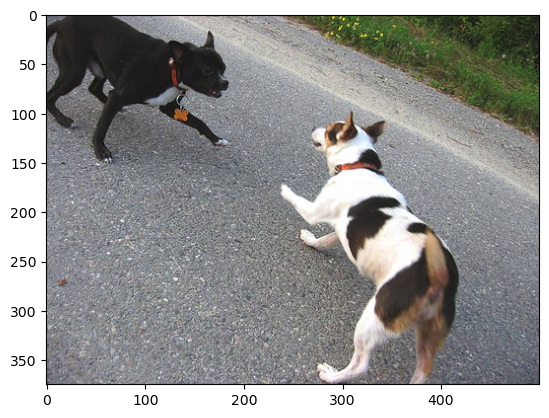

In [32]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass
--------------------Predicted--------------------
small girl is sitting in front of painted rainbow with her hands in bowl


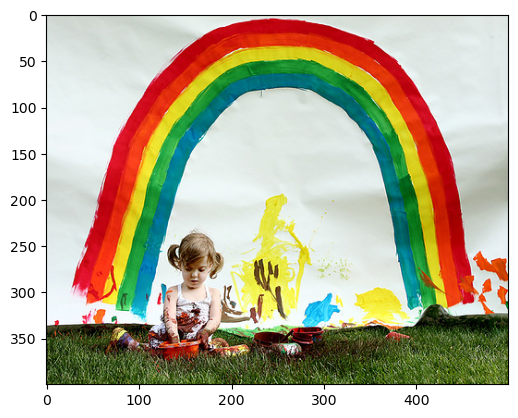

In [33]:
generate_caption("1002674143_1b742ab4b8.jpg")

## ------------------------------------------Prediction on unseen image-------------------------------------------

  0%|          | 0/11 [00:00<?, ?it/s]

woman in blue helmet and carriage off sharp rock


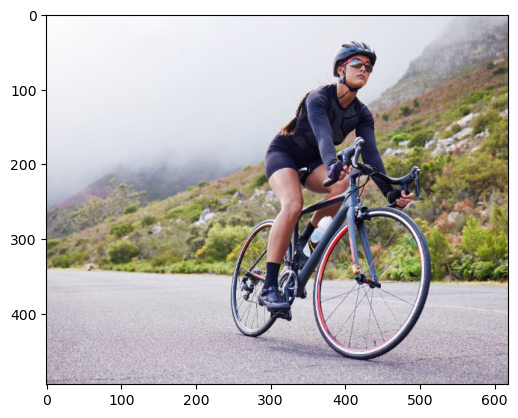

In [34]:
generate_caption("Screenshot 2023-08-30 100738.jpg")

  0%|          | 0/11 [00:00<?, ?it/s]

three biker in helmet riding his bicycle in the dirt wear from the dirt wear from the dirt wear street


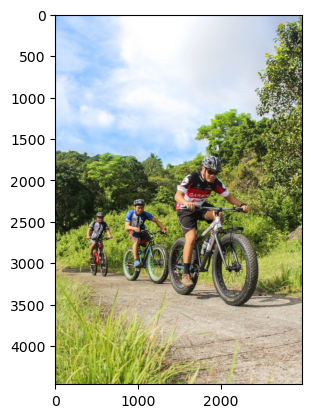

In [35]:
generate_caption("pexels-dó-castle-2158963.jpg")

  0%|          | 0/11 [00:00<?, ?it/s]

white dog is running through the air


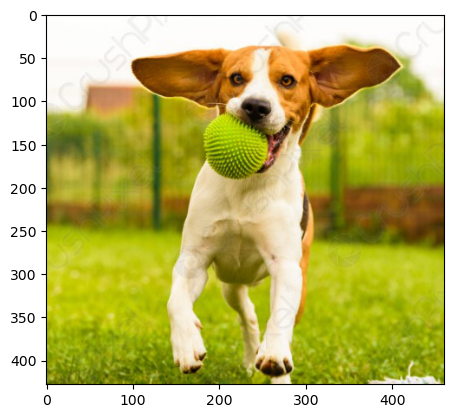

In [36]:
generate_caption("Screenshot 2023-09-05 090635.jpg")

  0%|          | 0/11 [00:00<?, ?it/s]

brown dog runs into the beach with pile of beach


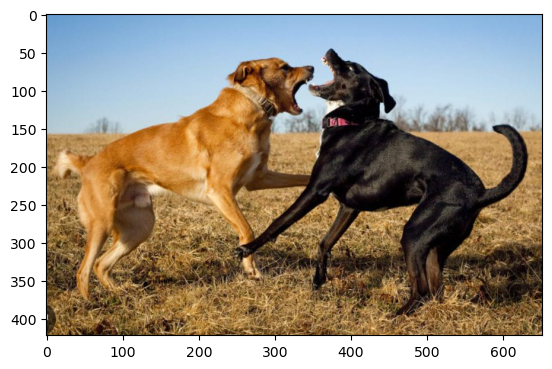

In [37]:
generate_caption("Screenshot 2023-09-05 123239.jpg")

## -------------------------------------------------------Thank You --------------------------------------------------------